In [1]:
from src.Visualizations import pyha_visualization
from src.pyha_visualization import local_line_graph
from src.TweetyNetAudio import load_wav
from src.Load_data_functions import multiclass_load_and_window_dataset
import pandas as pd
import numpy as np
import os
import sys
from src.Evaluation import evaluate_a_wav


In [2]:
import torch

print(torch.__version__)
print(torch)

1.10.0
<module 'torch' from 'e:\\programs\\envs\\tweety\\lib\\site-packages\\torch\\__init__.py'>


In [3]:
data_path=r"data\PYRE\Mixed_Bird-20220214T201520Z-001"
folder="Mixed_Bird"
csv_path=r"data\PYRE\for_data_science_newline_fixed.csv"
SR=44100
n_mels=86
frame_size=2048
hop_length=1024
windowsize=2

In [4]:
annotations=pd.read_csv(csv_path)
annotations.head()
annotations["MANUAL ID"].unique().size #948 unique ids

948

In [5]:
X, Y, UIDS = multiclass_load_and_window_dataset(data_path, folder, csv_path, SR, n_mels, frame_size, hop_length, windowsize)

data\PYRE\Mixed_Bird-20220214T201520Z-001\multi_downsampled_bin_mel_dataset.pkl
True
395 395 395 395
Windowing Spectrogram
2
time_bin: 0.023218997361477575
86.0
6020.0
(86, 6064)
6064
Hemitriccus-cohnhafti-97441.wav
Hemitriccus-cohnhafti-97441.wav
(86, 6064) (6064,)
6020 70
2
time_bin: 0.023153988868274585
86.0
258.0
(86, 308)
308
Chlorothraupis-carmioli-465622.wav
Chlorothraupis-carmioli-465622.wav
(86, 308) (308,)
258 3
2
time_bin: 0.023214079153928778
86.0
1462.0
(86, 1482)
1482
Geotrygon-violacea-506619.wav
Geotrygon-violacea-506619.wav
(86, 1482) (1482,)
1462 17
2
time_bin: 0.023209445979695282
86.0
1376.0
(86, 1381)
1381
Micrastur-buckleyi-30968.wav
Micrastur-buckleyi-30968.wav
(86, 1381) (1381,)
1376 16
2
time_bin: 0.02321149872913477
86.0
1290.0
(86, 1373)
1373
Phlogophilus-harterti-17394.wav
Phlogophilus-harterti-17394.wav
(86, 1373) (1373,)
1290 15
2
time_bin: 0.023203060036587394
86.0
774.0
(86, 859)
859
Ortalis-guttata-270874.wav
Ortalis-guttata-270874.wav
(86, 859) (859,)


([array([[40.398956, 72.97503 , 78.88795 , ..., 94.09912 , 87.49974 ,
          93.59578 ],
         [40.398956, 69.604546, 79.27565 , ..., 93.752045, 93.59574 ,
          94.193794],
         [40.398956, 62.566498, 80.32773 , ..., 79.91617 , 93.31902 ,
          93.42621 ],
         ...,
         [40.398956, 40.398956, 40.398956, ..., 54.64169 , 51.619244,
          52.617126],
         [40.398956, 40.48792 , 40.398956, ..., 48.49096 , 48.293747,
          51.786556],
         [40.398956, 40.398956, 40.398956, ..., 40.435326, 40.398956,
          53.856606]], dtype=float32),
  array([[81.354965, 86.043945, 71.82837 , ..., 75.729836, 79.5638  ,
          78.090645],
         [81.29159 , 76.314354, 76.549194, ..., 70.82181 , 82.211136,
          75.211235],
         [76.26903 , 71.33685 , 69.497665, ..., 80.00218 , 79.65045 ,
          74.186844],
         ...,
         [54.208378, 56.753178, 55.22751 , ..., 55.242657, 56.99124 ,
          56.719856],
         [52.391167, 53.886406, 54.

In [6]:
def kaliedoscope_format(df, filename):
    filtered_df = df[df["file"] == filename]
    #print(filtered_df["pred"])
    #print(len(filtered_df))
    if filtered_df.empty == True:
        print(f"file: {filename} was not in test set")
        return filtered_df
    sorted_filtered_df = filtered_df.sort_values("overall frame number")
    #print(sum(sorted_filtered_df["pred"]))
    time_bin_seconds = sorted_filtered_df.iloc[1]["temporal_frame_start_times"]
    #print(time_bin_seconds)
    zero_sorted_filtered_df = sorted_filtered_df[sorted_filtered_df["pred"] == 0]
    offset = zero_sorted_filtered_df["temporal_frame_start_times"]
    duration = zero_sorted_filtered_df["temporal_frame_start_times"].diff().shift(-1)
    intermediary_df = pd.DataFrame({"OFFSET": offset, "DURATION": duration})
    kaliedoscope_df = []
    if offset.iloc[0] != 0:
        kaliedoscope_df.append(pd.DataFrame({"OFFSET": [0], "DURATION": [offset.iloc[0]]}))
    kaliedoscope_df.append(intermediary_df[intermediary_df["DURATION"] >= 2*time_bin_seconds])
    if offset.iloc[-1] < sorted_filtered_df.iloc[-1]["temporal_frame_start_times"]:
        kaliedoscope_df.append(pd.DataFrame({"OFFSET": [offset.iloc[-1]], "DURATION": [sorted_filtered_df.iloc[-1]["temporal_frame_start_times"] + 
                                sorted_filtered_df.iloc[1]["temporal_frame_start_times"]]}))
    kaliedoscope_df = pd.concat(kaliedoscope_df)
    kaliedoscope_df = kaliedoscope_df.reset_index(drop=True)
    return kaliedoscope_df
    

In [7]:
def get_wav(filename, dataset_type):
    if dataset_type =="NIPS":
        Wav_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","train", filename)
        SR, SIGNAL = load_wav(Wav_path)
        return SR, SIGNAL, Wav_path
    elif dataset_type == "PYRE":
        Wav_path = os.path.join("data","PYRE","Mixed_Bird-20220126T212121Z-003", "Mixed_Bird", filename)
        SR, SIGNAL = load_wav(Wav_path)
        return SR, SIGNAL, Wav_path
    else:
        print(f"Dataset: {dataset_type} does not exist")
        return None
    

def get_premade_annotations(filename, csv, dataset_type):
    if dataset_type =="NIPS":
        premade_annotations_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","temporal_annotations_nips4b", csv)
        premade_annotations_df = pd.read_csv(premade_annotations_path, names=["OFFSET", "DURATION", "TAG"])
        return premade_annotations_df
    elif dataset_type == "PYRE":
        premade_annotations_path = os.path.join("data", "PYRE", csv)
        premade_annotations_df = pd.read_csv(premade_annotations_path)
        premade_annotations_df = premade_annotations_df[premade_annotations_df["IN FILE"] == filename]
        if len(premade_annotations_df) == 0:
            print(f"No premade annotations for file: {filename}")
        premade_annotations_df = premade_annotations_df[["OFFSET", "DURATION", "MANUAL ID"]]
        return premade_annotations_df
    else:
        print(f"Dataset: {dataset_type} does not exist")
        return None


In [8]:
def create_visualization(filename, csv, dataset_type):
    SR, SIGNAL, Wav_path = get_wav(filename, dataset_type)
    automated_annotations_path = os.path.join("data", "out", "Evaluation_on_data.csv")
    if automated_annotations_path == "":
        automated_df = pd.DataFrame()
    else:
        automated_df = pd.read_csv(automated_annotations_path)
        automated_df = kaliedoscope_format(automated_df, filename)
    #print(automated_df)
    premade_annotations_df = get_premade_annotations(filename, csv, dataset_type)
    premade_annotations_label = "Bird"
    #print(premade_annotations_df)
    
    # change local scores to what tweetynet returns.
    log_scale = True
    save_fig = False
    normalize_local_scores = False
    local_line_graph([0] * 216,
        Wav_path,
        SR,
        samples=SIGNAL,
        automated_df= automated_df,
        premade_annotations_df=premade_annotations_df,
        premade_annotations_label=premade_annotations_label,
        log_scale=log_scale,
        save_fig=save_fig,
        normalize_local_scores=normalize_local_scores)

In [9]:
#PYRE example
folder = os.path.join("data","PYRE", "Mixed_Bird-20220126T212121Z-003", "Mixed_Bird")
csv_file = "for_data_science_newline_fixed.csv"
files = os.listdir(folder)
#print(files)
#print(files[45])
create_visualization(files[0], csv_file, "PYRE")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\PYRE\\Mixed_Bird-20220126T212121Z-003\\Mixed_Bird'

file: nips4b_birds_trainfile002.wav was not in test set


e:\Q1-Project-Code\src\pyha_visualization.py:81: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0].set_yscale('log')


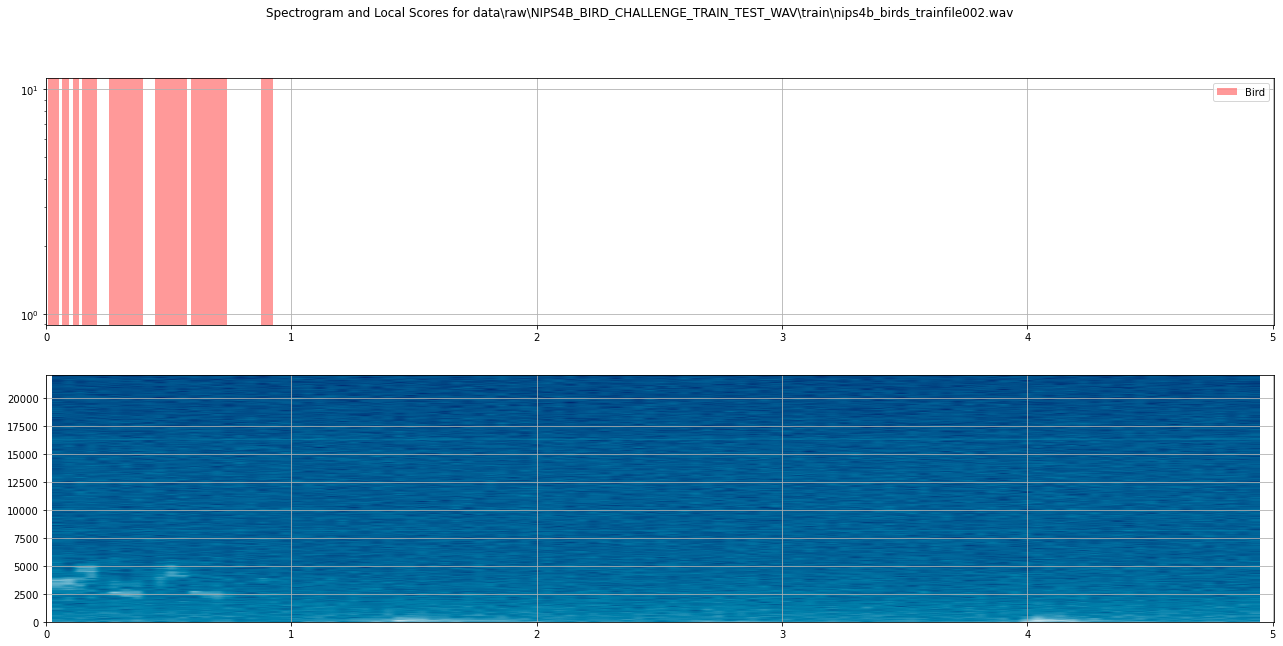

In [ ]:
#nips example
folder = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","train")
csv_folder = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","temporal_annotations_nips4b")
files = os.listdir(folder)
csvs = os.listdir(csv_folder)
#print(files[45])
create_visualization(files[1], csvs[1], "NIPS")

#use the evaluation_on_data.csv for this.

In [ ]:
automated_annotations_path = os.path.join("data", "out", "Evaluation_on_data.csv")
premade_annotations_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","temporal_annotations_nips4b","annotation_train001.csv")
Wav_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","train", "nips4b_birds_trainfile001.wav")
SR, SIGNAL = load_wav(Wav_path)
if automated_annotations_path == "":
    automated_df = pd.DataFrame()
else:
    automated_df = pd.read_csv(automated_annotations_path)
#print(automated_df.columns)
#add testing for kaliedoscope format
#automated_df.loc[0:50,"pred"] = 1
#automated_df.loc[100:150,"pred"] = 1
#automated_df.loc[175:198,"pred"] = 1
#automated_df.loc[200:215,"pred"] = 1
# Need to convert this df to kaliedoscope format
automated_df = kaliedoscope_format(automated_df, "nips4b_birds_trainfile001.wav")
print(automated_df)

premade_annotations_df = pd.read_csv(premade_annotations_path, names=["OFFSET", "DURATION", "TAG"])
premade_annotations_label = "Bird"
print(premade_annotations_df)
# change local scores to what tweetynet returns.
log_scale = True
save_fig = False
normalize_local_scores = False
local_line_graph([0] * 216,
    Wav_path,
    SR,
    samples=SIGNAL,
    automated_df= automated_df,
    premade_annotations_df=premade_annotations_df,
    premade_annotations_label=premade_annotations_label,
    log_scale=log_scale,
    save_fig=save_fig,
    normalize_local_scores=normalize_local_scores)

NameError: name 'load_wav' is not defined

In [ ]:
data_path = os.path.join('data', 'raw', 'NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV', 'train','nips4b_birds_trainfile001.wav')
csv_path = os.path.join(os.path.join(r"E:\Q1-Project-Code\data\out","NIPS_Annotations_condensed.csv"))
model_weights_path = os.path.join("data", "out", "model_weights-20220325_145032.h5")
local_scores, predictions = evaluate_a_wav(data_path, csv_path, model_weights_path)
#predictions.to_csv(f"{f}test_predictions.csv")
#only use pyha_visualization on the whold clip

pyha_visualization(local_scores, data_path, csv_path)


Compute features for nips4b_birds_trainfile001.wav
nips4b_birds_trainfile001.wav
Windowing Spectrogram
data\raw\NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV\train\nips4b_birds_trainfile001.wav
(86, 216) (216,)
215 5
(5, 86, 43)
(5, 1, 86, 43)
5
5
5
['0_data\\raw\\NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV\\train\\nips4b_birds_trainfile001.wav'
 '1_data\\raw\\NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV\\train\\nips4b_birds_trainfile001.wav'
 '2_data\\raw\\NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV\\train\\nips4b_birds_trainfile001.wav'
 '3_data\\raw\\NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV\\train\\nips4b_birds_trainfile001.wav'
 '4_data\\raw\\NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV\\train\\nips4b_birds_trainfile001.wav']
Using CPU 
Using cpu 
Sequential(
  (0): Conv2dTF(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=(8, 1), stride=(8, 1), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2dTF(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (4):

FileNotFoundError: [Errno 2] No such file or directory: 'data\\out\\model_weights-20220325_145032.h5'